In [ ]:
%%capture

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

print("Extracted Successfully")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import math
import cv2
import random
import datetime as dt

from collections import deque
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping


Install **pafy** library for youtube video download.

In [3]:
%%capture
!pip  install pafy youtube-dl moviepy

Choose a random seed and set it so that we will get same results during each iteration.

In [4]:
seed = 27
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

## **1. Download the data and perform EDA**
l I have used UCF50-Action Recognization Dataset, consisting of videos taken in real life. and available in Kaggle.


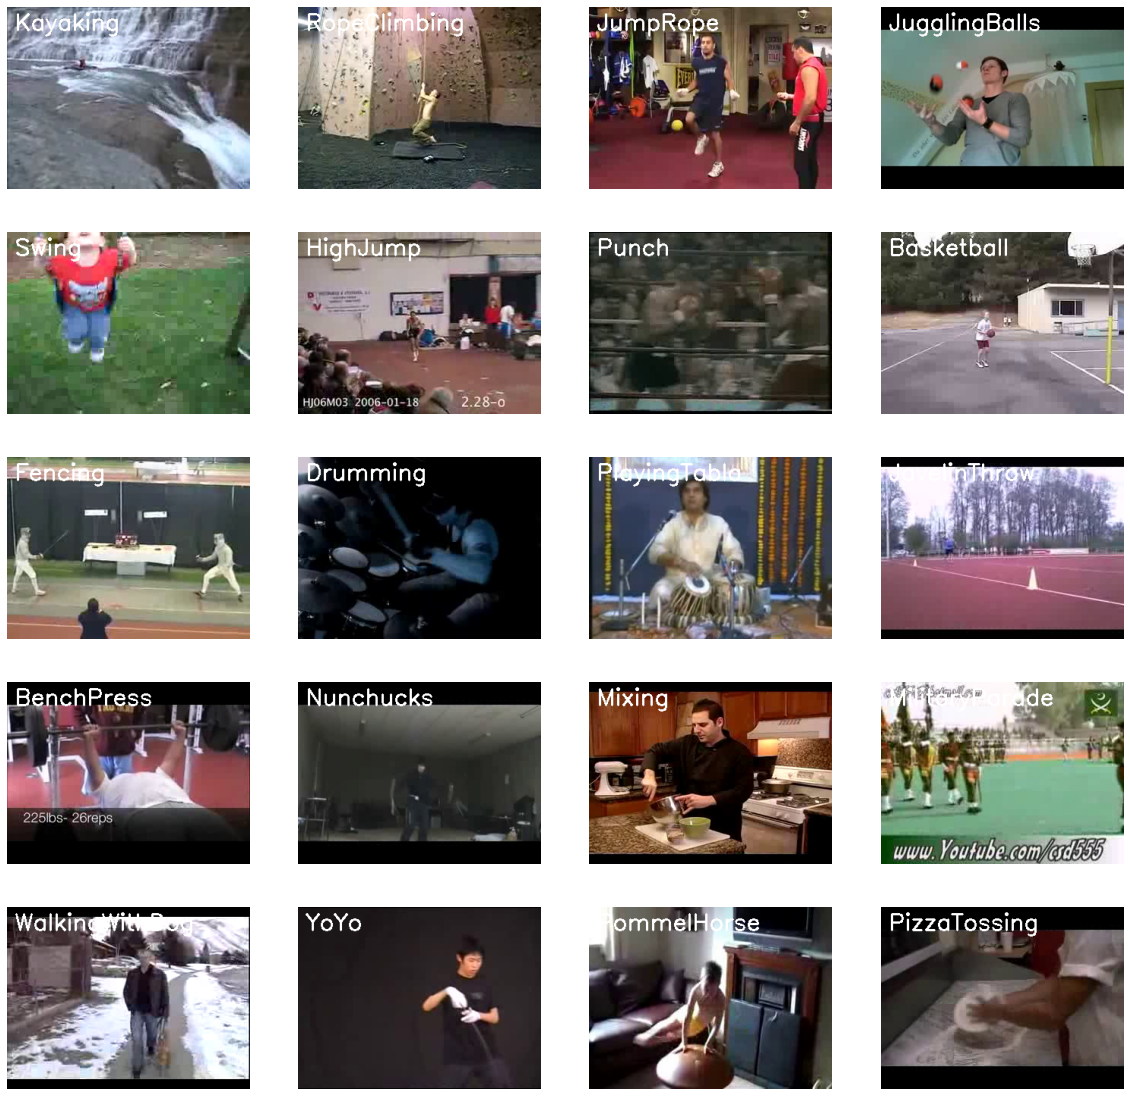

In [5]:
plt.figure(figsize=(20, 20))

# Get classnames
all_classes_names = os.listdir('/kaggle/input/ucf50/UCF50/')

# Randomly display 20 datapoints from the dataset 
rand_range = random.sample(range(len(all_classes_names)), 20)

for counter, index in enumerate(rand_range, 1):
    selected_class = all_classes_names[index]
    
    # retrieve all videos in the randomly selected directory
    video_files_names = os.listdir(f'/kaggle/input/ucf50/UCF50/{selected_class}')
    
    # select any file randomly from that class
    selected_video_file = random.choice(video_files_names)
    
    # read video with cv2
    video_read = cv2.VideoCapture(f'/kaggle/input/ucf50/UCF50/{selected_class}/{selected_video_file}')
    
    # start reading from first frame
    _, bgr_frame = video_read.read()
    
    video_read.release()
    
    # convert frame to standard rgb format
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    
    # display class name on video file
    cv2.putText(rgb_frame, selected_class, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # display frame
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')
        


In [6]:
# Get number of classes
len(all_classes_names)

50

## 2. Data PreProcessing

In [7]:
IMG_HEIGHT, IMG_WIDTH = 64, 64

# Specifying the sequence of data to be feed to LSTM
# If for a video of 5 sec I have 25fps then I will choose 30 frames from the 125 frames sampled uniformly
# Increasing the sequence length will increase the accuracy but also will increase the computation cost
SEQUENCE_LENGTH = 30

DATASET_DIR = '/kaggle/input/ucf50/UCF50/'

# Choose the classes that we will be used to classify
CLASSES_LIST = ['WalkingWithDog', 'TaiChi', 'Swing', 'HorseRace', 'Kayaking']

### **Extract frames from the video dataset and normalize it**

In [8]:
def frames_extraction(video_path):

    frames_list = [] # stores the frames
    video_reader = cv2.VideoCapture(video_path) # read video
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT)) # get the frames in that video
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1) # find skip interval length

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter*skip_frames_window) # set current frame position of video
        success, frame = video_reader.read() # read frame

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break
        
        resized_frame = cv2.resize(frame, (IMG_HEIGHT, IMG_WIDTH)) # resize the frame
        
        normalized_frame = resized_frame / 255 # normalize the frame
        
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

Create a function that will create the dataset.<br>
It will return the:
- Extracted frames
- Indices of the class associated with the video
- Path of the videos

In [9]:
dog = os.listdir(os.path.join(DATASET_DIR, 'WalkingWithDog')) # get list of video files present for that class
frames = frames_extraction(dog[0]) # extract frames from that video
frames

[]

In [10]:
def create_dataset():
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting data of class:{class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name)) # get list of video files present for that class
        
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name) # get complete path

            frames = frames_extraction(video_file_path) # extract frames from that video

            # if the choosen video has frames == SEQUENCE_LENGTH
            # then add it to the features list else skip the video

            if(len(frames)==SEQUENCE_LENGTH):
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.array(features)
    labels = np.array(labels)
    
    return features, labels, video_files_paths

In [11]:
features, labels, video_files_paths = create_dataset()

Extracting data of class:WalkingWithDog
Extracting data of class:TaiChi
Extracting data of class:Swing
Extracting data of class:HorseRace
Extracting data of class:Kayaking


In [12]:
# features
# labels
# video_files_paths

One hot encode the `labels`

In [13]:
one_hot_encoded_labels = to_categorical(labels)

In [14]:
one_hot_encoded_labels

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

## **Step 3. Split into training and testing**

In [15]:
f_train, f_test, l_train, l_test = train_test_split(features, one_hot_encoded_labels,
                                                   test_size = 0.25, shuffle = True,
                                                   random_state = seed)

## **Step 4. Implementation of ConvLSTM**

In [16]:
def create_convlstm_model():
    model = Sequential()
    
    # Model architecture
    # -------------------------------------------------------------------------------------------------------
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation  = 'tanh',data_format = 'channels_last',
                        recurrent_dropout=0.2, 
                        input_shape = (SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, 3), 
                        return_sequences = True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding = 'same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation  = 'tanh',data_format = 'channels_last',
                        recurrent_dropout=0.2, return_sequences = True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding = 'same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation  = 'tanh',data_format = 'channels_last',
                        recurrent_dropout=0.2, return_sequences = True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding = 'same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation  = 'tanh',data_format = 'channels_last',
                        recurrent_dropout=0.2, return_sequences = True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding = 'same', data_format='channels_last'))
    
    model.add(Flatten())
    
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))
    
    # -------------------------------------------------------------------------------------------------------
    # Print model summary
    model.summary()
    
    return model

Invoke the `create_convlstm_model()` function to create the `ConvLSTM` model and display it's symmary

In [17]:
conv_lstm = create_convlstm_model()

print("Model creation successful")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 30, 62, 62, 4)     1024      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 30, 31, 31, 4)     0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 31, 31, 4)     0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 30, 29, 29, 8)     3488      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 15, 15, 8)     0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 15, 15, 8)     0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 30, 13, 13, 14)    1

Use `plot_model()` function to get a beautiful view of the model architecture.

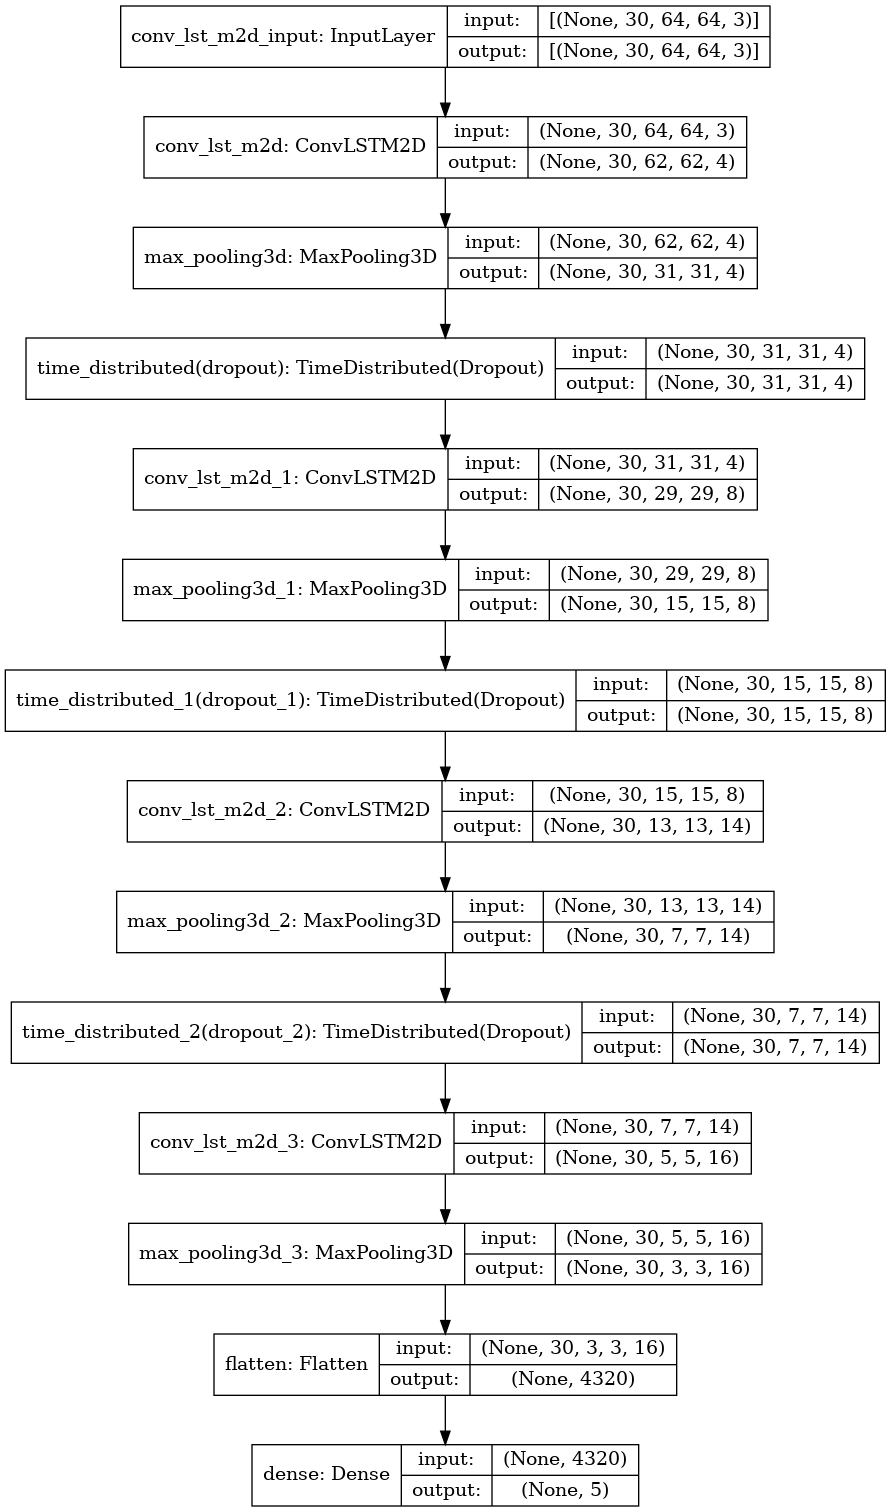

In [18]:
plot_model(conv_lstm, to_file='convlstm_model_architecture.png',
          show_shapes=True, show_layer_names = True)

#### **Compile and Train the Model**

In [19]:
%%time
# we can call Early Stopping Callback if we need
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# compile the model with loss as categorical_crossentropy

conv_lstm.compile(loss = 'categorical_crossentropy', optimizer='Adam',
                 metrics=['accuracy'])

# train the model
conv_lstm_train_hist = conv_lstm.fit(x = f_train, y = l_train, epochs = 50,
                                    batch_size = 5, shuffle = True, 
                                     validation_split=0.2, callbacks = [early_stopping_callback])

Epoch 1/50
78/78 [==============================] - 86s 868ms/step - loss: 1.6017 - accuracy: 0.2513 - val_loss: 1.5978 - val_accuracy: 0.2577
Epoch 2/50
78/78 [==============================] - 68s 866ms/step - loss: 1.5296 - accuracy: 0.3679 - val_loss: 1.3255 - val_accuracy: 0.4845
Epoch 3/50
78/78 [==============================] - 68s 868ms/step - loss: 1.2641 - accuracy: 0.5155 - val_loss: 1.2051 - val_accuracy: 0.5155
Epoch 4/50
78/78 [==============================] - 69s 887ms/step - loss: 1.0849 - accuracy: 0.5699 - val_loss: 1.4970 - val_accuracy: 0.4639
Epoch 5/50
78/78 [==============================] - 70s 894ms/step - loss: 0.9668 - accuracy: 0.6192 - val_loss: 1.4296 - val_accuracy: 0.4433
Epoch 6/50
78/78 [==============================] - 70s 898ms/step - loss: 0.7231 - accuracy: 0.7176 - val_loss: 1.0786 - val_accuracy: 0.5567
Epoch 7/50
78/78 [==============================] - 70s 893ms/step - loss: 0.6071 - accuracy: 0.7720 - val_loss: 0.8212 - val_accuracy: 0.6392

## **Evaluate the model**

In [20]:
model_evaluation_history = conv_lstm.evaluate(f_test, l_test)

6/6 [==============================] - 1s 119ms/step - loss: 0.7788 - accuracy: 0.7081


## **Save the Model**

In [22]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'Conv_LSTM_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
conv_lstm.save(model_file_name)

## **Plot the model metrics**

In [23]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

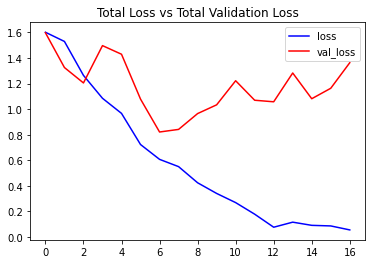

In [24]:
# Visualize the training and validation loss metrices.
plot_metric(conv_lstm_train_hist, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')